<a href="https://colab.research.google.com/github/barbaractong/motor-imagery/blob/main/prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.5 MB/s eta 0:00:00


In [ ]:
import gdown
import glob
import math
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal

from numpy.fft import fft
from scipy.io import loadmat
from sklearn.model_selection import KFold

## Loading the data

- **Calibration data**: In the **first two runs**, arrows pointing left, right, or down were presented as visual cues on a computer screen. **Cues were displayed for a period of 4s during which the subject was instructed to perform the cued motor imagery task.** These periods were interleaved with 2s of blank screen and 2s with a fixation cross shown in the center of the screen. The fixation cross was superimposed on the cues, i.e. it was shown for 6s. These data sets are provided with complete marker information.

In [ ]:
# download data from repository to colab - .mat files (1000Hz samples)
!gdown --folder https://drive.google.com/drive/folders/1mMD7zs-H86a7taNh72k4qblaVAbMycm3

Retrieving folder list
Processing file 1srzjwbJyJrIEESYwvbgiDBltFggs7KLr BCICIV_calib_ds1a_1000Hz.mat
Processing file 1PPxsVuseZPBIGdDGKdGOqBh2QCBytHid BCICIV_calib_ds1b_1000Hz.mat
Processing file 1t33ezNoxsR9iTk_1JBSjpsfI4UKznTw9 BCICIV_calib_ds1c_1000Hz.mat
Processing file 1-MBgaMhi3p2oLtg-Qi48RQum5_yu0N78 BCICIV_calib_ds1d_1000Hz.mat
Processing file 1gA1DHlOOi_0Tg8c9XxnLUvBajrRy9jow BCICIV_calib_ds1e_1000Hz.mat
Processing file 1B86Jdt_Z1fLf66s70i-FIG4X5Zt8GvKm BCICIV_calib_ds1f_1000Hz.mat
Processing file 1ccseyvUZ9hdjXYShLf8I_3S-ROOCUVGF BCICIV_calib_ds1g_1000Hz.mat
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1srzjwbJyJrIEESYwvbgiDBltFggs7KLr
To: /content/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1a_1000Hz.mat
100% 225M/225M [00:02<00:00, 78.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PPxsVuseZPBIGdDGKdGOqBh2QCBytHid
To: /content/BCICIV_1calib_1000Hz_mat/BCICIV_

In [ ]:
def load_mat_file(fpath):
  return loadmat(fpath, struct_as_record = True)

path = '/content/BCICIV_1calib_1000Hz_mat'
dataFiles = r''+path+'/*.mat'
files = glob.glob(dataFiles)
files.sort()

tranning_data = [load_mat_file(f) for f in files]

In [ ]:
files

['/content/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1a_1000Hz.mat',
 '/content/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1b_1000Hz.mat',
 '/content/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1c_1000Hz.mat',
 '/content/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1d_1000Hz.mat',
 '/content/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1e_1000Hz.mat',
 '/content/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1f_1000Hz.mat',
 '/content/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1g_1000Hz.mat']

In [ ]:
print(f"Loaded .mat data: {len(tranning_data)}")
print(f"Loaded .mat files in gdrive: {len(files)}")

Loaded .mat data: 7
Loaded .mat files in gdrive: 7


### Data Prep

In [ ]:
sample = tranning_data[0]

In [ ]:
type(sample)

dict

In [ ]:
sample.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cnt', 'mrk', 'nfo'])

**Dict description:**

Data are provided in Matlab format (*.mat) containing variables:

- cnt: the continuous EEG signals, size [time x channels]. The array is stored in datatype INT16. To convert it to uV values, use cnt= 0.1*double(cnt); in Matlab.
- mrk: structure of target cue information with fields (the file of evaluation data does not contain this variable)
  - pos: vector of positions of the cue in the EEG signals given in unit sample, length #cues
  - y: vector of target classes (-1 for class one or 1 for class two), length #cues
- nfo: structure providing additional information with fields
  - fs: sampling rate,
  - clab: cell array of channel labels,
  - classes: cell array of the names of the motor imagery classes,
  - xpos: x-position of electrodes in a 2d-projection,
ypos: y-position of electrodes in a 2d-projection.

In [ ]:
sample_uV = sample['cnt']*0.1 # Converting to uV. TODO: normalize the data

In [ ]:
target = sample['mrk']['y'][0][0][0]

In [ ]:
target.shape

(200,)

In [ ]:
position = sample['mrk']['pos'][0][0][0]

### Training matrix: each line has the last column with the class value (1 or -1)

In [ ]:
position_with_class = np.vstack((position, target)).T

In [ ]:
tranning_matrix = np.zeros((sample_uV.shape[0], sample_uV.shape[1] + 1))

In [ ]:
for i in position:
    tranning_matrix[i, 0:59] = sample_uV[i, :]

IndexError: ignored

In [ ]:
for idx, i in enumerate(position):
  tranning_matrix[i, 59] = target[idx]

In [ ]:
tranning_matrix[20913, :]

array([106. ,  46.9, 117.5, 149.7,  92.1, 180.6, 131.9, 171.2,  88.9,
       104. ,  78.6, 134.4, 149.4,  44.1,  82.7, 127.8, 115.2, 135.2,
       163.8, 124.9, 141.2, 114.7, 155.1, 156.4, 131.9, 125.5, 133.6,
       133.3, 178.2, 129.9, 144.1, 143.4, 140.5,  80.9,  19.4,  87. ,
       118.8, 189.5, 143.5,  90.8, 101.3, 117.7, 115.5, 116.9, 177.5,
       107.2,  61.8, 150.6, 103.7, 125.6, 103.3, 116.1,  62.8, 134.2,
       117.1, 135.6, 123.3, 145.6, 107.5,   1. ])

In [ ]:
tranning_matrix = tranning_matrix[~np.all(tranning_matrix == 0, axis=1)]

In [ ]:
# Extract given param - Sample rate
sample_rate = sample['nfo']['fs'][0][0][0][0]
print(f"Sample rate: {sample_rate}Hz")

Sample rate: 1000Hz


In [ ]:
# Extract given param - Channel names
channel_id = [cid[0] for cid in sample['nfo']['clab'][0][0][0]]

In [ ]:
classes =  [cls[0] for cls in sample['nfo']['classes'][0][0][0]]

print(classes) # TODO: Check the classes for the others samples

['left', 'foot']


### Exploratory analysis

In [ ]:
n_sampes, n_channels = sample_uV.shape

In [ ]:
T = n_sampes/sample_rate # period
t = np.arange(0, T, 1/sample_rate) # time
f = np.arange(0, sample_rate, 1/T) # frequency

In [ ]:
print(f"Period (T): {T}s.")

Period (T): 1905.94s.


In [ ]:
# time plot function
def time_plot(data, t, channels, sample_rate, interval):

  fig = plt.figure(figsize=(12, 8))
  plt.rcParams.update({"font.size": 14})
  start_plot = math.floor(interval[0]*sample_rate)
  end_plot = math.floor(interval[1]*sample_rate)

  for i in range(3):

    ax = fig.add_subplot(3, 1, i + 1)
    ax.plot(t[start_plot:end_plot], data[start_plot:end_plot, i])
    ax.set_ylabel(channels[i])

    if(i==2):

      ax.set_xlabel('Time (s)')

  plt.show()

In [ ]:
channel_id

['AF3',
 'AF4',
 'F5',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F6',
 'FC5',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'FC6',
 'CFC7',
 'CFC5',
 'CFC3',
 'CFC1',
 'CFC2',
 'CFC4',
 'CFC6',
 'CFC8',
 'T7',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'CCP7',
 'CCP5',
 'CCP3',
 'CCP1',
 'CCP2',
 'CCP4',
 'CCP6',
 'CCP8',
 'CP5',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'CP6',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'PO1',
 'PO2',
 'O1',
 'O2']

In [ ]:
channels_for_model = []
for idx, c in enumerate(channel_id):
  if c in ('C3', 'C4', 'Cz'):
    channels_for_model.append({"id": c, "idx": idx})

In [ ]:
channels_for_model

[{'id': 'C3', 'idx': 26}, {'id': 'Cz', 'idx': 28}, {'id': 'C4', 'idx': 30}]

In [ ]:
raw_data = sample_uV[:, [26, 28, 30]]

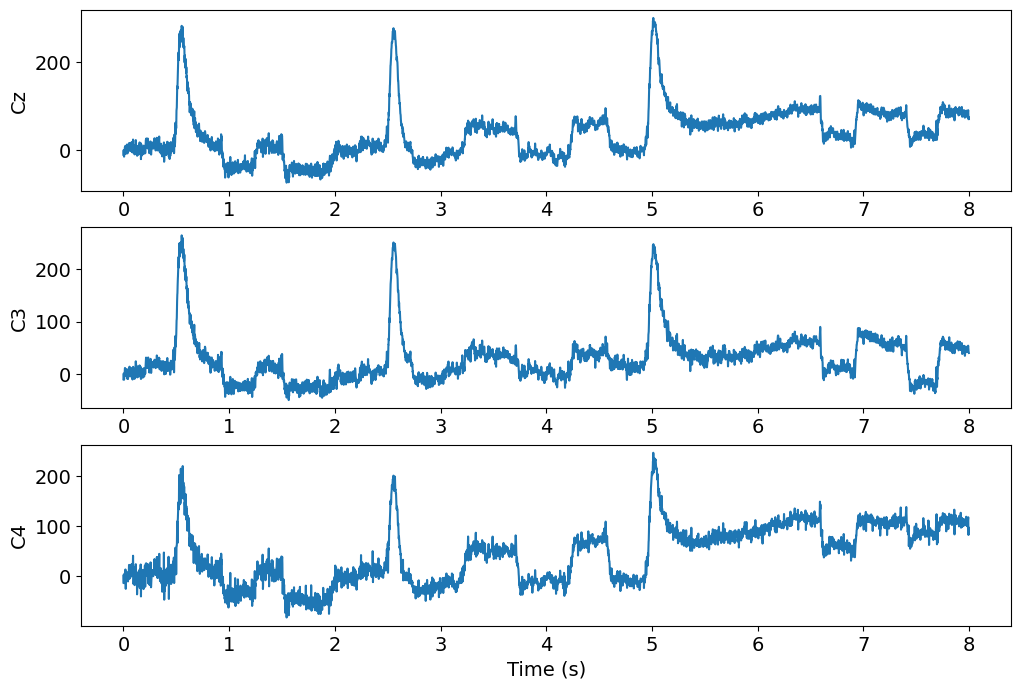

In [ ]:
time_plot(data=sample_uV, t=t, sample_rate=sample_rate,
          channels=['Cz', 'C3', 'C4'], interval=[0, 8]) # 8s

In [ ]:
# fft plot function
def fft_plot(data, f, channels, T, interval):

  fig = plt.figure(figsize=(12, 8))
  plt.rcParams.update({"font.size": 14})
  start_plot = math.floor(interval[0]*T)
  end_plot = math.floor(interval[1]*T)

  for i in range(3):

    ax = fig.add_subplot(3, 1, i + 1)
    ax.plot(f[start_plot:end_plot], data[start_plot:end_plot, i])
    ax.set_ylabel(channels[i])

    if(i==2):

      ax.set_xlabel('Frequency (Hz)')

  plt.show()

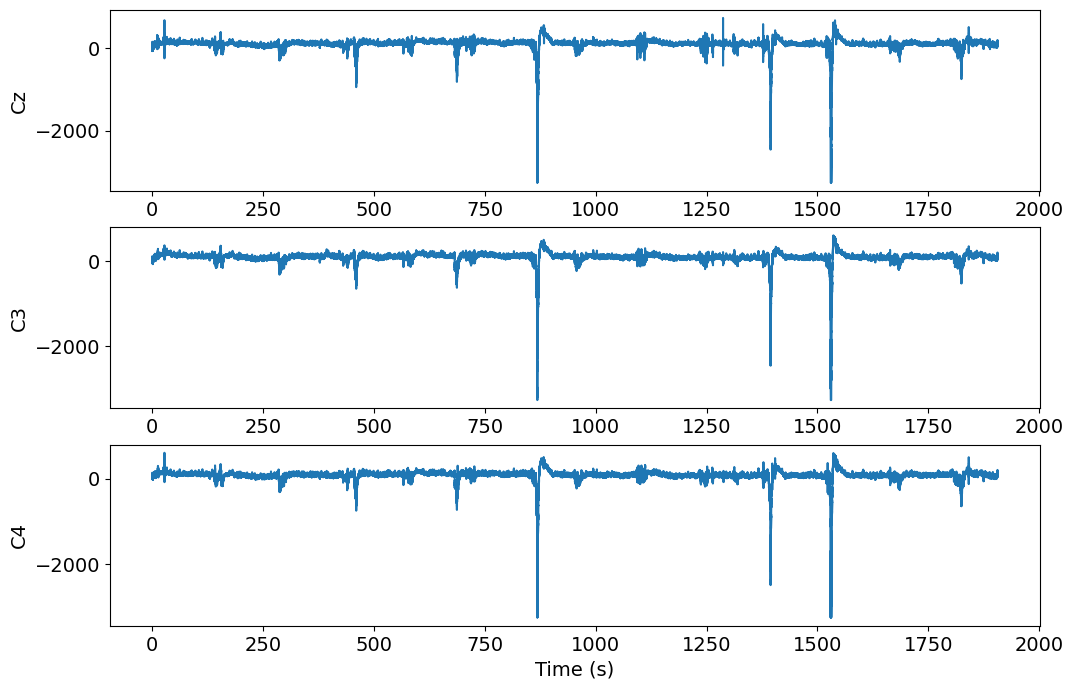

In [ ]:
# time plot data, for one minute
time_plot(raw_data, t, ['Cz', 'C3', 'C4'], sample_rate, [0, 2000])

In [ ]:
raw_data.shape

(1905940, 3)

In [ ]:
# slice the signal
sliced_raw = raw_data[:, :]

In [ ]:
sample_rate = 100

T = sliced_raw.shape[0]/sample_rate # period
t = np.arange(0, T, 1/sample_rate) # time
f = np.arange(0, sample_rate, 1/T) # frequency

In [ ]:
sliced_raw.shape

(1905940, 3)

In [ ]:
f.shape

(1905941,)

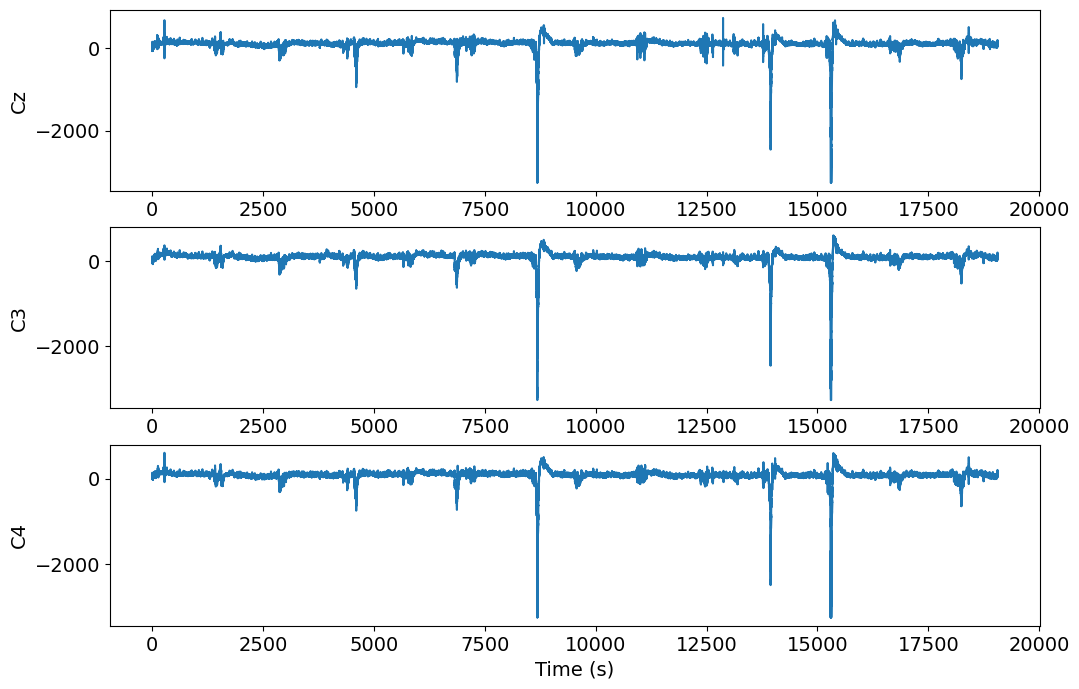

In [ ]:
# time plot data, for one minute
time_plot(sliced_raw, t, ['Cz', 'C3', 'C4'], sample_rate, [0, 1905941])

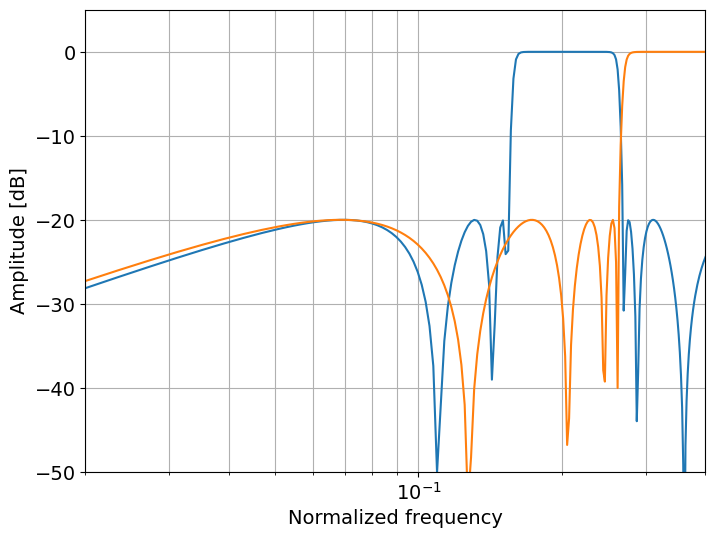

In [ ]:
# alpha and beta filter
fp = np.array([[8, 13], [13.5, 30]])
fs = np.array([[7.5, 13.5], [13, 30.5]])
wp = fp/(sample_rate/2)
ws = fs/(sample_rate/2)

gpass = [1, 3]
gstop = 20

fig = plt.figure(figsize=(8, 6))
plt.rcParams.update({"font.size": 14})
ax = fig.add_subplot(1, 1, 1)


for i in range(wp.shape[0]):

  N, Wn = signal.cheb2ord(wp[i, :], ws[i, :], gpass[i], gstop)
  b, a = signal.cheby2(N, gstop, Wn, 'bandpass')
  w, h = signal.freqz(b, a)
  ax.semilogx(w/np.pi, 20*np.log10(abs(h)))

ax.set_xlabel('Normalized frequency')
ax.set_ylabel('Amplitude [dB]')
ax.grid(which='both', axis='both')
ax.axis([0.02, 0.4, -50, 5])
plt.show()

In [ ]:
sample_rate

100

In [ ]:
## Janelamento
def data_windowing(data, windows_len, sample_rate):
  n_samples = data.shape[0]
  n_channels = data.shape[1]

  n_dims = len(data.shape)

  n_windows = windows_len*sample_rate

  start_at = np.rint(
      np.arange(0, n_samples - n_windows + 1, n_windows)).astype(int)

  end_at = (start_at + np.rint(n_windows)).astype(int)

  for i in range(len(start_at)):

    cut_data = data[start_at[i]:end_at[i],]
    expand_data = np.expand_dims(cut_data, n_dims-1)

    if i == 0:

      seg_data = expand_data

    else:

      seg_data = np.concatenate((seg_data, expand_data), n_dims-1)

  return seg_data

In [ ]:
sample_seg = data_windowing(sample_uV[:, [26, 28, 30]], 2, 1000)

In [ ]:
sample_rate = 100

T = sample_seg[0].shape[0]/sample_rate # period
t = np.arange(0, T, 1/sample_rate) # time
f = np.arange(0, sample_rate, 1/T) # frequency

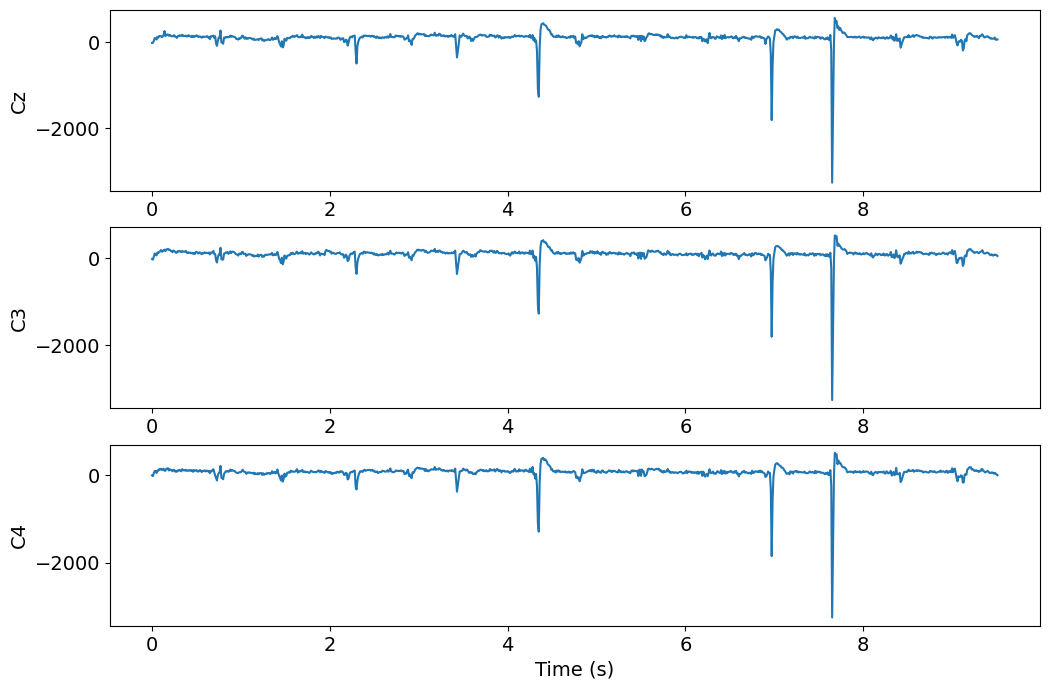

In [ ]:
# time plot data, for one minute
time_plot(sample_seg[0], t, ['Cz', 'C3', 'C4'], sample_rate, [0, 600])

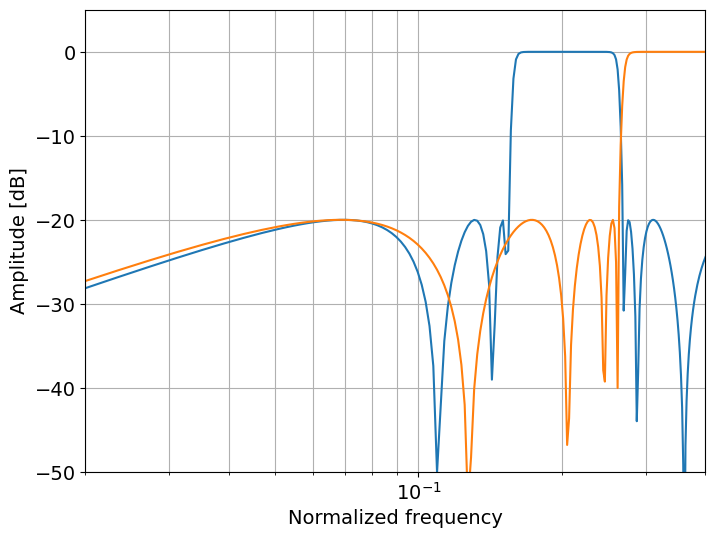

In [ ]:
# alpha and beta filter
fp = np.array([[8, 13], [13.5, 30]])
fs = np.array([[7.5, 13.5], [13, 30.5]])
wp = fp/(sample_rate/2)
ws = fs/(sample_rate/2)

gpass = [1, 3]
gstop = 20

fig = plt.figure(figsize=(8, 6))
plt.rcParams.update({"font.size": 14})
ax = fig.add_subplot(1, 1, 1)

for i in range(wp.shape[0]):

  N, Wn = signal.cheb2ord(wp[i, :], ws[i, :], gpass[i], gstop)
  b, a = signal.cheby2(N, gstop, Wn, 'bandpass')
  w, h = signal.freqz(b, a)
  ax.semilogx(w/np.pi, 20*np.log10(abs(h)))

ax.set_xlabel('Normalized frequency')
ax.set_ylabel('Amplitude [dB]')
ax.grid(which='both', axis='both')
ax.axis([0.02, 0.4, -50, 5])
plt.show()

In [ ]:
# alpha and beta filters
N_alpha, Wn_alpha = signal.cheb2ord(wp[0, :], ws[0, :], gpass[0], gstop)
sos_alpha = signal.cheby2(N_alpha, gstop, Wn_alpha, 'bandpass', output='sos')
N_beta, Wn_beta = signal.cheb2ord(wp[1, :], ws[1, :], gpass[1], gstop)
sos_beta = signal.cheby2(N_beta, gstop, Wn_beta, 'bandpass', output='sos')

In [ ]:
alpha_seg_data = signal.sosfilt(sos_alpha, sample_seg, axis=0)
beta_seg_data = signal.sosfilt(sos_beta, sample_seg, axis=0)

In [ ]:
alpha_seg_data.shape

(2000, 952, 3)

In [ ]:
fft_alpha= np.abs(fft(alpha_seg_data, axis=0))

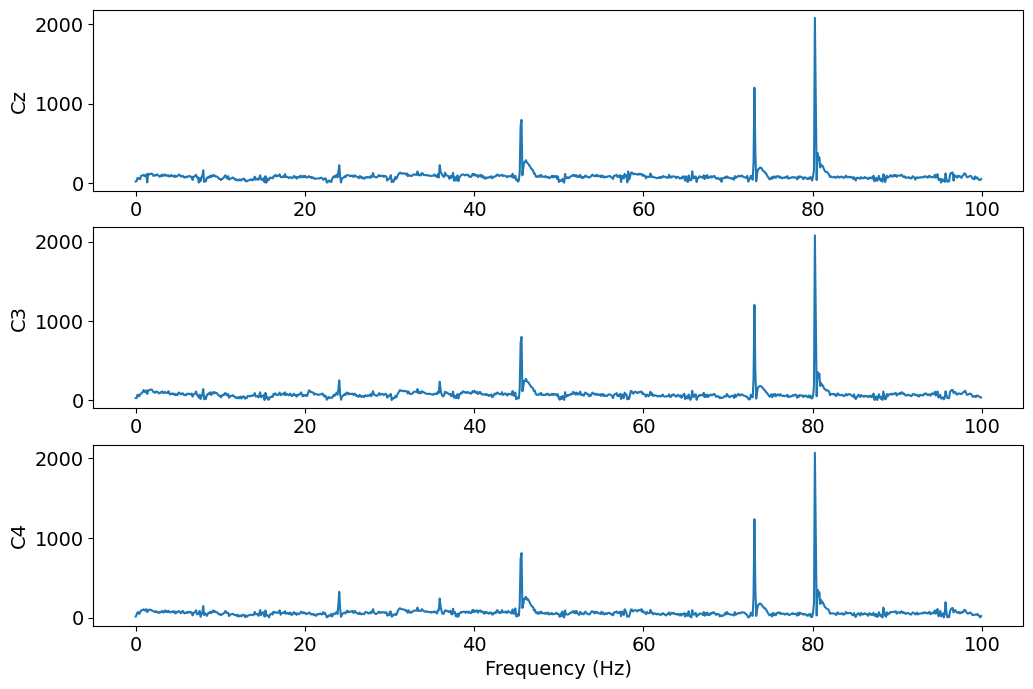

In [ ]:
fft_plot(fft_alpha[0], f, ['Cz', 'C3', 'C4'], T, [0,200])

In [ ]:
fft_beta= np.abs(fft(beta_seg_data, axis=0))

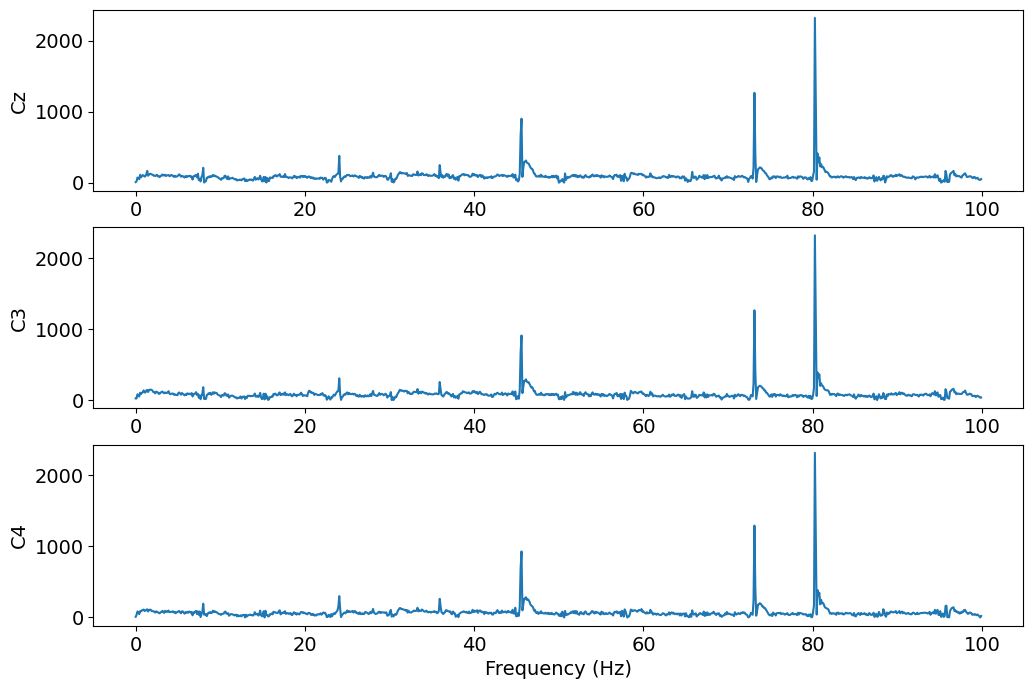

In [ ]:
fft_plot(fft_beta[0], f, ['Cz', 'C3', 'C4'], T, [0,200])

In [ ]:
# fft comparing plot function
def fft_comparing_plot(data1, data2, f, ch_names, T, interval):

  N_channels = len(ch_names)
  fig = plt.figure(figsize=(12, 8))
  plt.rcParams.update({"font.size": 14})
  start_plot = math.floor(interval[0]*T)
  end_plot = math.floor(interval[1]*T)

  for i in range(N_channels):

    ax = fig.add_subplot(N_channels, 1, i + 1)
    ax.plot(f[start_plot:end_plot], data1[start_plot:end_plot, i])
    ax.plot(f[start_plot:end_plot], data2[start_plot:end_plot, i])
    ax.set_ylabel(ch_names[i])

    if(i==1):

      ax.set_xlabel('Frequency (Hz)')
      ax.legend(['Alfa', 'Beta'])

  plt.show()

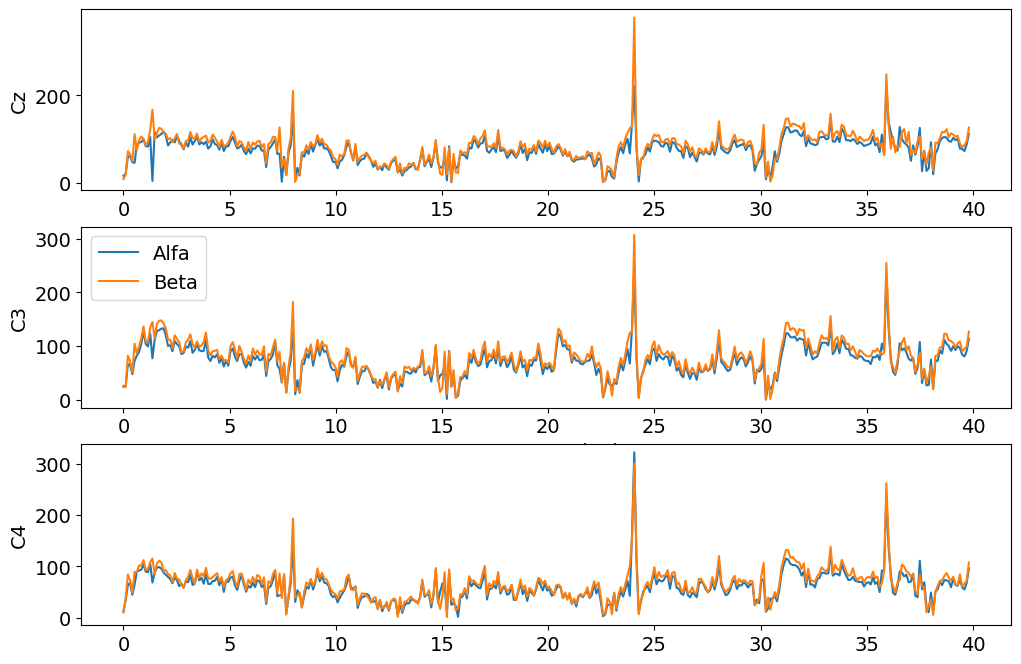

In [ ]:
fft_comparing_plot(fft_alpha[0], fft_beta[0],
                   f, ['Cz', 'C3', 'C4'], T, [0, 40])

In [ ]:
# kfold cross validation
kf = KFold(n_splits=5, shuffle=True)

In [ ]:
def cov_matrix_estimation(seg_data):

  N_dims = len(seg_data.shape)

  for i in range(seg_data.shape[2]):

    np_cov = np.cov(np.matrix.transpose(seg_data[:, :, i]))
    expand_data = np.expand_dims(np_cov, N_dims-1)

    if i == 0:

      cov_data = expand_data

    else:

      cov_data = np.concatenate((cov_data, expand_data), N_dims-1)

  mean_cov_data = np.mean(cov_data, axis=N_dims-1)

  return mean_cov_data

In [ ]:
cov_matrix = cov_matrix_estimation(alpha_seg_data)

In [ ]:
cov_matrix.shape

(952, 952)

In [ ]:
# alpha feature space before filtering
log_var_alpha = np.log(np.var(alpha_seg_data, axis=0))

In [ ]:
# alpha feature space before filtering
log_var_beta = np.log(np.var(beta_seg_data, axis=0))